In [170]:
# BM 336546 - HW2
# Part I: Data Exploration


In [171]:
# Loading Data

import sys
import pandas as pd 
import numpy as np
from pathlib import Path
import random
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import hinge_loss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from tqdm import tqdm
%load_ext autoreload


T1D_dataset = pd.read_csv("HW2_data.csv") 
T1D = T1D_dataset[['Age','Gender','Increased Urination','Increased Thirst','Sudden Weight Loss','Weakness','Increased Hunger',
                            'Genital Thrush','Visual Blurring','Itching','Irritability','Delayed Healing','Partial Paresis',
                            'Muscle Stiffness','Hair Loss','Obesity','Family History']]
Diagnosis = T1D_dataset[['Diagnosis']]

random.seed(10)  # fill your seed number here
T1D_features=T1D.copy()
T1D.sample(n=5, random_state=5)#Display data of five random patient 




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Family History
197,62,Male,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,Yes,No,Yes,No,0
330,40,Male,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Yes,1
261,30,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
336,30,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,1
539,67,Male,No,No,No,No,NaN,No,Yes,NaN,No,No,No,NaN,No,No,0


In [172]:
# replacing nans with samples

i=T1D_features.columns.values

T1Dc_features={}    
for x in i:
    Q = T1D_features[x]
    null_ind=np.where(Q.isnull())[0]
   
    for ii in null_ind:
        Q.iloc[ii] = Q.iloc[np.random.choice(np.where(Q.notnull())[0])]
    T1Dc_features[x] = Q
    

T1Dc_features=pd.DataFrame(T1Dc_features)
T1Dc_features.sample(n=5, random_state=5)


C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Family History
197,62,Male,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,Yes,No,Yes,No,0
330,40,Male,No,No,Yes,No,No,No,No,No,No,No,No,No,No,Yes,1
261,30,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
336,30,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,1
539,67,Male,No,No,No,No,No,No,Yes,Yes,No,No,No,Yes,No,No,0


In [173]:
# T1Dc_features = pd.get_dummies(data=T1Dc_features, drop_first=True)
# T1Dc_features.sample(n=5, random_state=5)


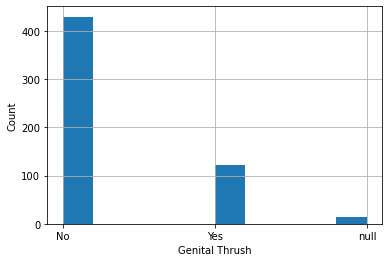

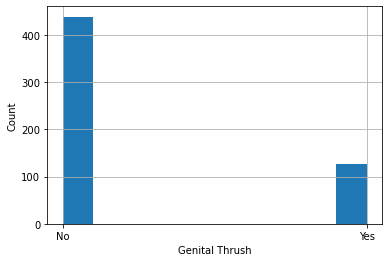

In [174]:
# Make sure that we have no Null values left
feat = 'Genital Thrush' #pick a feature
Q = pd.DataFrame(T1D[feat])

idx_na = Q.index[Q[feat].isnull()].tolist()

for i in idx_na:
    Q.loc[idx_na] = "null"

Q[feat].hist(bins = 10)
plt.xlabel('Genital Thrush')
plt.ylabel('Count')
plt.show()

T1Dc_features[feat].hist(bins = 10)
plt.xlabel('Genital Thrush')
plt.ylabel('Count')
plt.show()

In [175]:
# axarr = T1Dc_features.hist(bins=50, figsize=(20, 15)) # histograms of dataframe variables
# for idx, ax in enumerate(axarr.flatten()):
# #     ax.set_xlabel(i[idx])
#     ax.set_ylabel("Count")
# plt.show()


In [176]:
#section 2: test-train split

orig_feat = T1Dc_features.columns.values
X_train, X_test, y_train, y_test = train_test_split(T1Dc_features, np.ravel(Diagnosis), test_size=0.2, random_state=0, stratify=np.ravel(Diagnosis))

# print(len(X_train))
# print(len(X_test))
# print(len(y_train))
# print(len(y_test))



In [177]:
#3-a
# print((X_train.iloc[:,1:]=='Yes') + (X_train.iloc[:,1:]=='Male') + (X_train.iloc[:,1:]==1))
tbl1=[]
# q=(X_train.iloc[:,1:]=='Yes')
# print((X_train.iloc[:,1:]=='Yes').sum())
tbl1={'Train %':((X_train.iloc[:,1:]=='Yes') | 
                 (X_train.iloc[:,1:]=='Male') | (X_train.iloc[:,1:]==1))
      .sum()*100/len(X_train)}
tbl1['Test %']=((X_test.iloc[:,1:]=='Yes') | (X_test.iloc[:,1:]=='Male') 
                | (X_test.iloc[:,1:]==1)).sum()*100/len(X_test)
tbl1['Delta %']=tbl1['Train %']-tbl1['Test %']
print(pd.DataFrame(tbl1))

                       Train %     Test %   Delta %
Gender               63.938053  62.831858  1.106195
Increased Urination  48.230088  48.672566 -0.442478
Increased Thirst     45.796460  42.477876  3.318584
Sudden Weight Loss   39.823009  46.017699 -6.194690
Weakness             56.415929  60.176991 -3.761062
Increased Hunger     44.690265  42.477876  2.212389
Genital Thrush       21.460177  26.548673 -5.088496
Visual Blurring      45.796460  41.592920  4.203540
Itching              49.336283  45.132743  4.203540
Irritability         23.008850  25.663717 -2.654867
Delayed Healing      46.902655  43.362832  3.539823
Partial Paresis      42.699115  42.477876  0.221239
Muscle Stiffness     35.840708  37.168142 -1.327434
Hair Loss            34.292035  41.592920 -7.300885
Obesity              17.477876  14.159292  3.318584
Family History       50.221239  52.212389 -1.991150


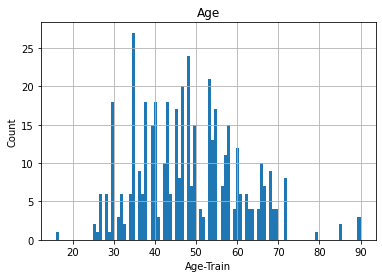

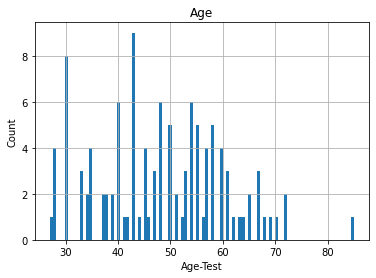

In [178]:
#compare Age distribution
feat = 'Age'
Q=X_train[[feat]]
Q.hist(bins = 100)

plt.xlabel('Age-Train')
plt.ylabel('Count')
plt.show()

q=X_test[['Age']]
q.hist(bins = 100)

plt.xlabel('Age-Test')
plt.ylabel('Count')
plt.show()

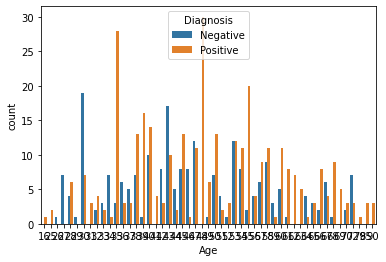

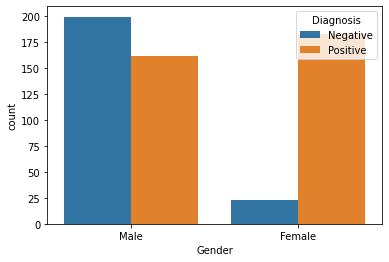

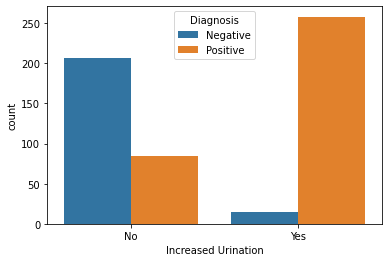

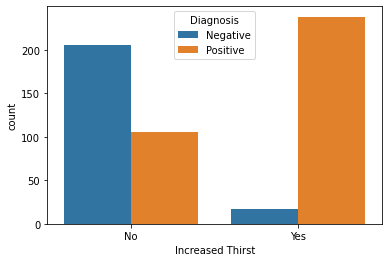

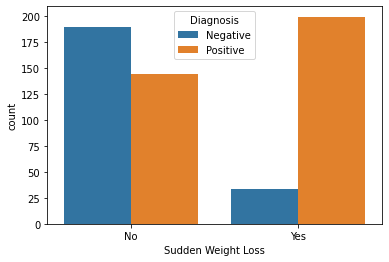

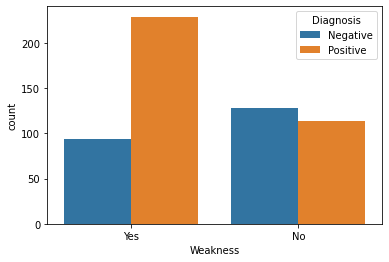

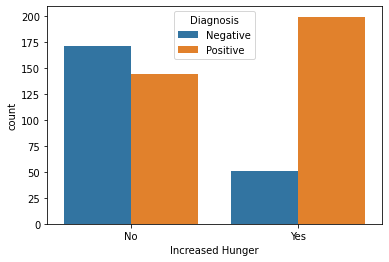

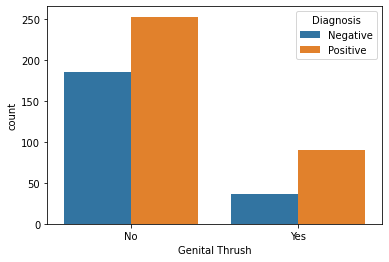

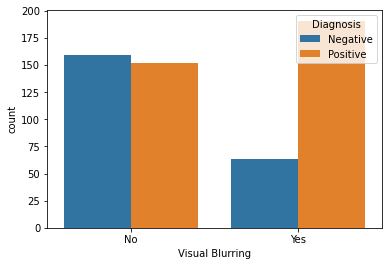

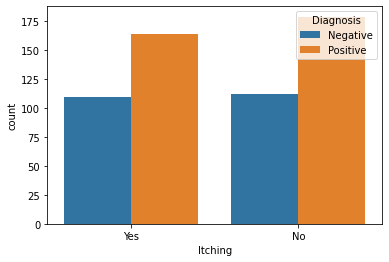

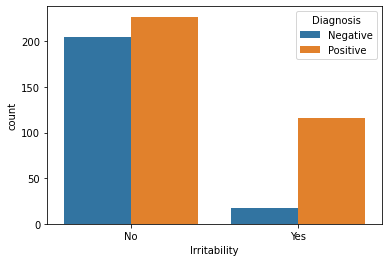

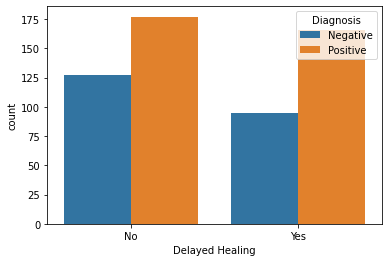

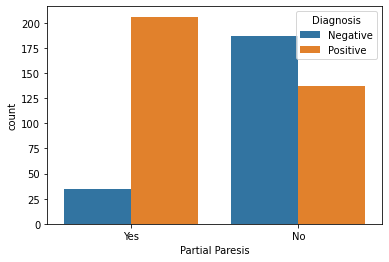

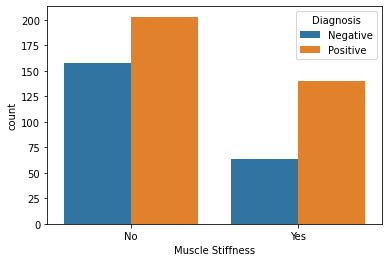

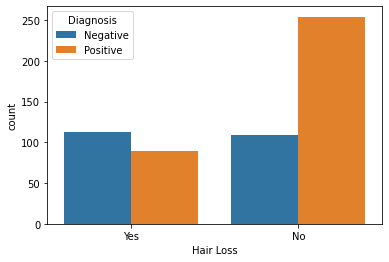

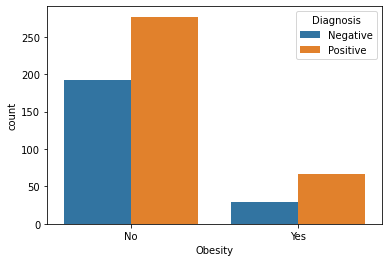

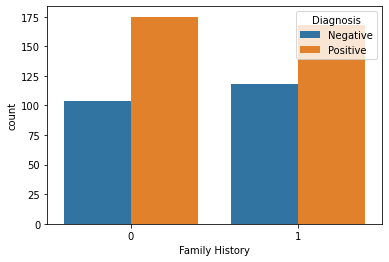

In [179]:
#3-b: relationship between feature and label

data_plotting=T1Dc_features.copy()
data_plotting['Diagnosis']=Diagnosis
features = T1Dc_features.columns.values
for feat in features:
    ax = sns.countplot(x=feat, hue="Diagnosis", data=data_plotting) 
   
    plt.show()
    

In [180]:
# #3-cIT HAS TO BE NUMERIC
# plt.figure(figsize = (10,8))
# sns.heatmap(T1Dc_features.corr(), annot = True)

In [181]:
#Section 4 - Hot Vector
# hot_vector=data_plotting.copy()
# hot_vector['Diagnosis']=pd.get_dummies(data=hot_vector['Diagnosis'],drop_first=True)
# del hot_vector['Age']
# print(hot_vector)
X_train = pd.get_dummies(data=X_train, drop_first=True)
X_test = pd.get_dummies(data=X_test, drop_first=True)
y_train = np.ravel(pd.get_dummies(data=y_train, drop_first=True))
y_test = np.ravel(pd.get_dummies(data=y_test, drop_first=True))


In [182]:
def plot_radar(clf, clf_type):
    labels=np.array(['Accuracy', 'F1', 'PPV', 'Sensitivity', 'AUROC']) 
    score_mat_train = np.stack((clf.cv_results_['mean_train_accuracy'], clf.cv_results_['mean_train_f1'],
                               clf.cv_results_['mean_train_precision'], clf.cv_results_['mean_train_recall'],
                               clf.cv_results_['mean_train_roc_auc']), axis=0)
    score_mat_val = np.stack((clf.cv_results_['mean_test_accuracy'], clf.cv_results_['mean_test_f1'],
                               clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall'],
                               clf.cv_results_['mean_test_roc_auc']), axis=0)


    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

    angles=np.concatenate((angles,[angles[0]]))
    cv_dict = clf.cv_results_['params']
    fig=plt.figure(figsize=(18,14))
    if 'svm__gamma' in cv_dict[0]:
        new_list = [(i, item) for i, item in enumerate(cv_dict) if
                    item["svm__kernel"] == clf_type[0] and item["svm__gamma"] == clf_type[1]]
    else:
        new_list = [(i, item) for i, item in enumerate(cv_dict) if
                    item["svm__kernel"] == clf_type[0]]
    for idx, val in enumerate(new_list):
        ax = fig.add_subplot(1, len(new_list), 1+idx, polar=True)
        rel_idx, rel_dict = val
        stats_train = score_mat_train[:, rel_idx]
        stats_train=np.concatenate((stats_train,[stats_train[0]]))
        ax.plot(angles, stats_train, 'o-', linewidth=2)
        ax.fill(angles, stats_train, alpha=0.25)
        stats_val = score_mat_val[:, rel_idx]
        stats_val=np.concatenate((stats_val,[stats_val[0]]))
        ax.plot(angles, stats_val, 'o-', linewidth=2)
        ax.fill(angles, stats_val, alpha=0.25)
        ax.set_thetagrids(angles[0:-1] * 180/np.pi, labels)
        if idx == 0:
            ax.set_ylabel(clf_type[0], fontsize=18)
        ax.set_title('C = %.3f' % (rel_dict['svm__C']))
        if 'svm__gamma' in cv_dict[0]:
            ax.set_xlabel('$\gamma = %s $' % (rel_dict['svm__gamma']))
        ax.set_ylim([0,1])
        ax.legend(['Train','Validation'])
        ax.grid(True)
        
    plt.show()

In [183]:
#Linear section 5-1
#Model 1 - SVM
n_splits = 5 #5k cross fold
skf = StratifiedKFold(n_splits=n_splits, random_state=10, shuffle=True)
svc = SVC(probability=True)
C = np.array([0.001, 0.01, 1, 10, 100, 1000])

pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', svc)])
svm_lin = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['linear']},cv=skf,
                       scoring=['accuracy','f1','precision','recall','roc_auc'], 
                       refit='roc_auc', verbose=3, return_train_score=True)
svm_lin.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.870, test=0.802), f1=(train=0.898, test=0.850), precision=(train=0.852, test=0.785), recall=(train=0.950, test=0.927), roc_auc=(train=0.954, test=0.917), total=   0.1s
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.814, test=0.868), f1=(train=0.862, test=0.900), precision=(train=0.784, test=0.831), recall=(train=0.959, test=0.982), roc_auc=(train=0.955, test=0.974), total=   0.0s
[CV] svm__C=0.001, svm__kernel=linear ................................
[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.865, test=0.800), f1=(train=0.895, test=0.842), precision=(train=0.849, test=0.800), recall=(train=0.945, test=0.889), roc_auc=(train=0.957, test=0.926), total=   0.0s
[CV] svm__C=0.001, svm__kernel=linear ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  svm__C=0.001, svm__kernel=linear, accuracy=(train=0.812, test=0.844), f1=(train=0.862, test=0.883), precision=(train=0.777, test=0.815), recall=(train=0.968, test=0.964), roc_auc=(train=0.954, test=0.950), total=   0.0s
[CV] svm__C=0.01, svm__kernel=linear .................................
[CV]  svm__C=0.01, svm__kernel=linear, accuracy=(train=0.898, test=0.879), f1=(train=0.913, test=0.899), precision=(train=0.938, test=0.907), recall=(train=0.890, test=0.891), roc_auc=(train=0.976, test=0.960), total=   0.0s
[CV] svm__C=0.01, svm__kernel=linear .................................
[CV]  svm__C=0.01, svm__kernel=linear, accuracy=(train=0.909, test=0.879), f1=(train=0.923, test=0.893), precision=(train=0.947, test=0.958), recall=(train=0.900, test=0.836), roc_auc=(train=0.972, test=0.980), total=   0.0s
[CV] svm__C=0.01, svm__kernel=linear .................................
[CV]  svm__C=0.01, svm__kernel=linear, accuracy=(train=0.909, test=0.856), f1=(train=0.923, test=0.869), precis

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([1.e-03, 1.e-02, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svm__kernel': ['linear']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [184]:
best_svm_lin = svm_lin.best_estimator_
print(svm_lin.best_params_)

{'svm__C': 1.0, 'svm__kernel': 'linear'}


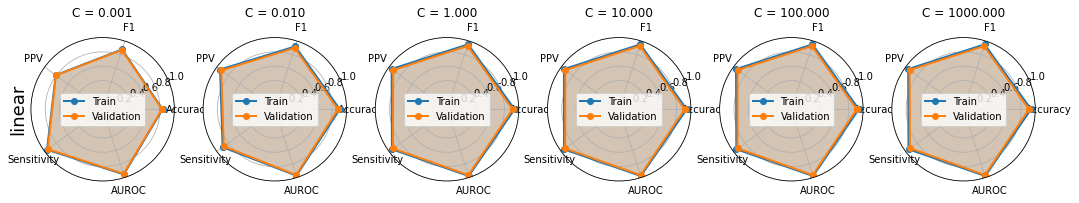

In [185]:
#compare C's
clf_type = ['linear']
plot_radar(svm_lin,clf_type)

6/6 lambda values, processed folds: 100%|████████████████████████████████████████████████| 5/5 [00:00<00:00, 51.16it/s]


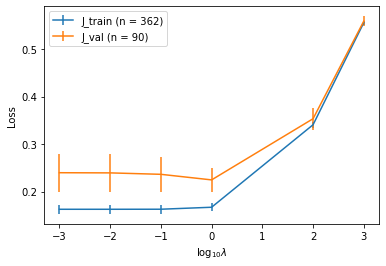

In [189]:
#Linear model 2 - logistic
pen = 'l2'
CC = np.array([0.001, 0.01, 1, 10, 100, 1000]) #1/lambda
scaler = StandardScaler()

J_train = np.zeros((2,len(CC)))
J_val = np.zeros((2,len(CC)))

for idx, C in enumerate(CC):
    
    #--------------------------Impelment your code here:-------------------------------------
    log_reg = LogisticRegression(random_state=5, penalty='l2', C = C, max_iter=2000,solver='lbfgs')
    #----------------------------------------------------------------------------------------
    with tqdm(total=n_splits, file=sys.stdout, position=0, leave=True) as pbar:
        h = 0 # index per split per lambda
        J_train_fold = np.zeros(n_splits)
        J_val_fold = np.zeros(n_splits)

        for train_index, val_index in skf.split(X_train, y_train):
            pbar.set_description('%d/%d lambda values, processed folds' % ((1 + idx), len(CC)))
            pbar.update()
            #--------------------------Impelment your code here:-------------------------------------
            x_train_fold, x_val_fold = X_train.to_numpy()[train_index,:], X_train.to_numpy()[val_index,:]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            x_train = scaler.fit_transform(x_train_fold)
            x_val = scaler.transform(x_val_fold)
            log_reg.fit(x_train, y_train_fold)
            y_pred_train = log_reg.predict_proba(x_train)
            y_pred_val = log_reg.predict_proba(x_val)
            J_train_fold[h]=log_loss(y_train_fold,y_pred_train)
            J_val_fold[h]=log_loss(y_val_fold,y_pred_val)
#             #----------------------------------------------------------------------------------------
            h += 1
        #--------------------------Impelment your code here:-------------------------------------
        J_train[:,idx] = [np.mean(J_train_fold),np.std(J_train_fold)]
        J_val[:,idx] = [np.mean(J_val_fold),np.std(J_val_fold)]

plt.errorbar(np.log10(1/CC), J_train[0,:], yerr=J_train[1,:])
plt.errorbar(np.log10(1/CC), J_val[0,:], yerr=J_val[1,:]) 
plt.xlabel('$\log_{10}\lambda$')
plt.ylabel('Loss')
plt.legend(['J_train (n = ' + str(x_train_fold.shape[0]) + ')', 'J_val (n = ' + str(x_val_fold.shape[0]) + ')'])

In [206]:
#As can be seen in the graph C with the most suitable value is C=1, then 
# log_reg = LogisticRegression(random_state=5, penalty='l2', C = C, max_iter=2000,solver='lbfgs')
# LOSS=J_train[0,0]
log_reg = LogisticRegression(random_state=3)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
log_reg=LogisticRegression(random_state=10)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(random_state=10)

In [196]:
#5a-2: non-linear model SVM
C = np.array([1, 100, 1000])#, 10, 100, 1000])
pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', svc)])
svm_nonlin = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['rbf', 'poly'],
                                                      'svm__gamma': ['auto', 'scale']},
                       scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
                       refit='roc_auc', verbose=3, return_train_score=True)
svm_nonlin.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] svm__C=1, svm__gamma=auto, svm__kernel=rbf ......................
[CV]  svm__C=1, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.989, test=0.956), f1=(train=0.991, test=0.963), precision=(train=0.991, test=0.981), recall=(train=0.991, test=0.945), roc_auc=(train=0.999, test=0.994), total=   0.0s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=rbf ......................
[CV]  svm__C=1, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.986, test=0.945), f1=(train=0.989, test=0.954), precision=(train=0.991, test=0.963), recall=(train=0.986, test=0.945), roc_auc=(train=0.999, test=0.993), total=   0.1s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=rbf ......................
[CV]  svm__C=1, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.986, test=0.922), f1=(train=0.989, test=0.933), precision=(train=0.986, test=0.961), recall=(train=0.991, test=0.907), roc_auc=(train=0.999, test=0.991), total=   0.0s
[CV] svm__C=1, svm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  svm__C=1, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.986, test=0.956), f1=(train=0.989, test=0.964), precision=(train=0.982, test=0.964), recall=(train=0.995, test=0.964), roc_auc=(train=0.999, test=0.995), total=   0.0s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=rbf ......................
[CV]  svm__C=1, svm__gamma=auto, svm__kernel=rbf, accuracy=(train=0.986, test=0.978), f1=(train=0.989, test=0.982), precision=(train=0.991, test=0.982), recall=(train=0.986, test=0.982), roc_auc=(train=0.999, test=0.998), total=   0.0s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=poly .....................
[CV]  svm__C=1, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.989, test=0.967), f1=(train=0.991, test=0.972), precision=(train=0.991, test=0.981), recall=(train=0.991, test=0.964), roc_auc=(train=1.000, test=0.993), total=   0.0s
[CV] svm__C=1, svm__gamma=auto, svm__kernel=poly .....................
[CV]  svm__C=1, svm__gamma=auto, svm__kernel=poly, accuracy=(train=0.989, test

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': array([   1,  100, 1000]),
                         'svm__gamma': ['auto', 'scale'],
                         'svm__kernel': ['rbf', 'poly']},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [197]:
#Choose the best estimator and name it as best_svm_nonlin.
best_svm_nonlin = svm_nonlin.best_estimator_
print(svm_nonlin.best_params_)

{'svm__C': 100, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}


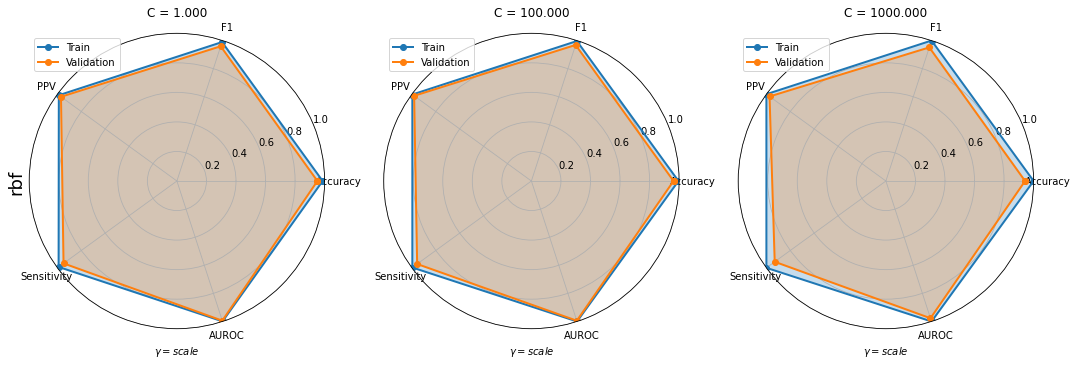

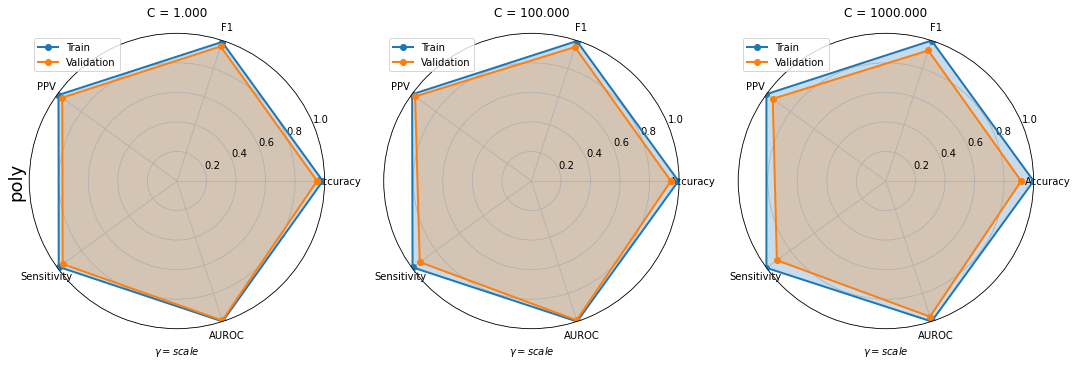

In [198]:
clf_type = ['rbf', 'scale']
plot_radar(svm_nonlin, clf_type)
clf_type = ['poly', 'scale']
plot_radar(svm_nonlin, clf_type)

In [225]:
calc_TN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 0]
calc_FP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 1]
calc_FN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 0]
calc_TP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 1]

def Evaluation_metrics(x_train,x_test,model,method):
    y_pred_test = model.predict(x_test) #NOTICE NOT TO USE THE STANDARDIZED DATA.
    y_pred_proba_test = model.predict_proba(x_test)
    #--------------------------Impelment your code here:-------------------------------------
#     if method=='log_reg' :
#          LOSS=log_loss(y_test,y_pred_test)
#     else: #lin_SVM/ non-lin_SVM
#         y_pred_test_sc=np.where(y_pred_test==0, -1, y_pred_test)
#         y_test_sc=np.where(y_test==0, -1, y_test)
#         LOSS=hinge_loss(y_test_sc,y_pred_test_sc)

    TN = calc_TN(y_test, y_pred_test)
    TP = calc_TP(y_test, y_pred_test)
    FN = calc_FN(y_test, y_pred_test)
    FP = calc_FP(y_test, y_pred_test)
    Se = TP/(TP+FN)
    Sp = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    Acc = (TP+TN)/(TP+TN+FP+FN)
    F1 = (2*PPV*Se)/(PPV+Se)
    print(f'Sensitivity is {Se:.2f}')
    print(f'Specificity is {Sp:.2f}')
    print(f'PPV is {PPV:.2f}')
    print(f'NPV is {NPV:.2f}')
    print(f'Accuracy is {Acc:.2f}')
    print(f'F1 is {F1:.2f}')
#     print(f'LOSS is {LOSS:.2f}')
    plot_confusion_matrix(svm_lin, x_test, y_test, cmap=plt.cm.Blues)
    plt.grid(False)
    #------------------------------------------------------------------------------------------
    print('AUROC is {:.3f}'.format(roc_auc_score(y_test, y_pred_proba_test[:,1])))

Sensitivity is 0.94
Specificity is 0.82
PPV is 0.89
NPV is 0.90
Accuracy is 0.89
F1 is 0.92
AUROC is 0.954


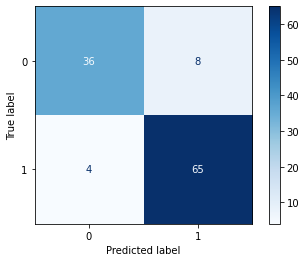

In [226]:
#5b:
#Linear 1
Evaluation_metrics(X_train,X_test,best_svm_lin,method='lin_SVM')

C:\Users\user\anaconda3\envs\bm-336546\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in longlong_scalars


Sensitivity is 0.00
Specificity is 1.00
PPV is nan
NPV is 0.39
Accuracy is 0.39
F1 is nan
AUROC is 0.667


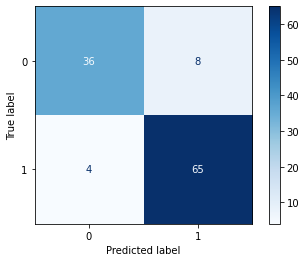

In [227]:
#Linear 2
Evaluation_metrics(X_train,X_test,log_reg,'log_reg')

Sensitivity is 0.96
Specificity is 0.91
PPV is 0.94
NPV is 0.93
Accuracy is 0.94
F1 is 0.95
AUROC is 0.976


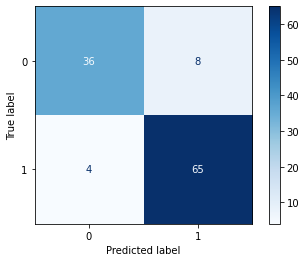

In [228]:
#Non-linear 
Evaluation_metrics(X_train,X_test,best_svm_nonlin,'SVM')

Sensitivity is 0.90
Specificity is 0.89
PPV is 0.93
NPV is 0.85
Accuracy is 0.89
F1 is 0.91
AUROC is 0.969


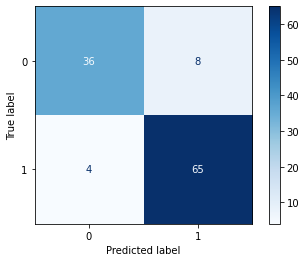

In [221]:
#section 6-random forest
from sklearn.metrics import plot_confusion_matrix, roc_auc_score,plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
rfc = Pipeline(steps=[('scale', StandardScaler()), ('rfc', RandomForestClassifier(max_depth=4, random_state=0, criterion='gini'))])
rfc.fit(X_train, y_train)
# importance = rfc.feature_importances_

Evaluation_metrics(rfc,'rf')

In [222]:
#7a-
#scaling

scale=StandardScaler()
# del X_train['Age']
# del X_test['Age']

X_train_scaled=scale.fit_transform(X_train)
X_test_scaled=scale.transform(X_test)
# X_train_scaled=np.where(X_train==0, -1, X_train)
# X_test_scaled=np.where(X_test==0, -1, X_test)
n_components = 2
#---------------------------Implement your code here:------------------------
pca=PCA(n_components,whiten=True)
X_train_pca=pca.fit_transform(X_train_scaled)
X_test_pca=pca.transform(X_test_scaled)
#----------------------------------------------------------------------------

In [223]:
def plt_2d_pca(X_pca,y):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, aspect='equal')
    ax.scatter(X_pca[y==0, 0], X_pca[y==0, 1], color='b')
    ax.scatter(X_pca[y==1, 0], X_pca[y==1, 1], color='r')
    ax.legend(('Negative','Positive'))
    ax.plot([0], [0], "ko")
    ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
    ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
    ax.set_xlabel('$U_1$')
    ax.set_ylabel('$U_2$')
    ax.set_title('2D PCA')

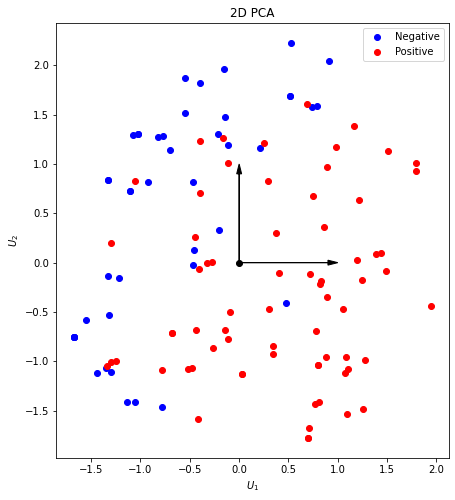

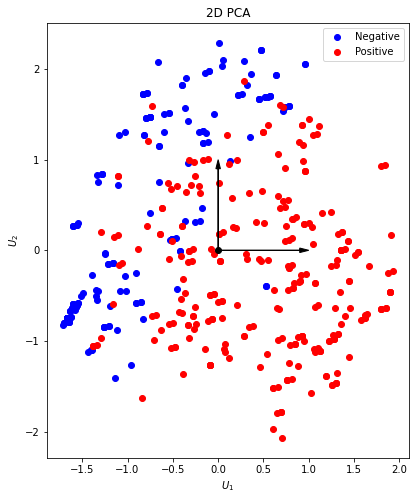

In [224]:
plt_2d_pca(X_test_pca,y_test)
plt_2d_pca(X_train_pca,y_train)


In [ ]:
#7c
